# По следам модельного эксперимента

$n=20, \quad m=200, \quad m_0=150$,

$\mathbf{X}_i \sim \mathcal{N}(0, 1), \quad i=1,\dots,m_0;$

$\mathbf{X}_i \sim \mathcal{N}(1, 1), \quad i=m_0+1,\dots,m;$

$\mathbf{X}_i \in \mathbb{R}^n.$

**Гипотезы:**

$H^i_0: \mathsf{E}\mathbf{X}_i = 0$;

$H^i_1: \mathsf{E}\mathbf{X}_i \neq 0$;

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sns
import pandas as pd

In [2]:
m = 200
m0 = 150
n = 20
rs = np.random.RandomState(42)

X = rs.randn(m,n)
X[m0:]+=1

Гистограммы

(array([0.01620078, 0.07290352, 0.1636279 , 0.28513376, 0.3564172 ,
        0.36775774, 0.22357079, 0.09720469, 0.03240156, 0.00486023]),
 array([-1.92944869, -1.31219452, -0.69494036, -0.07768619,  0.53956797,
         1.15682214,  1.77407631,  2.39133047,  3.00858464,  3.6258388 ,
         4.24309297]),
 <a list of 10 Patch objects>)

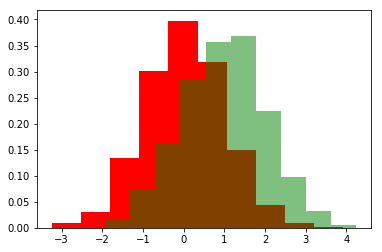

In [3]:
plt.hist(X[:m0].flatten(), color='r', density=True)
plt.hist(X[m0:].flatten(), color='g', alpha=0.5, density=True)

Для проверки используем одновыборочный критерий Стьюдента.

In [4]:
from statsmodels.stats.weightstats import ttest_ind
# zero mean
rejected = 0
for x in X[:m0]:
    if st.ttest_1samp(x, 0)[1]<=0.05:    
        rejected+=1
print ('True: H0; H0 not rejected:', m0 - rejected)
print ('True: H0; H0 rejected:', rejected)

# non-zero mean
rejected = 0
for x in X[m0:]:
    if st.ttest_1samp(x, 0)[1]<=0.05:
        rejected+=1
print ('True: H1; H0 not rejected:', m - m0 - rejected)
print ('True: H1; H0 rejected:', rejected)


True: H0; H0 not rejected: 139
True: H0; H0 rejected: 11
True: H1; H0 not rejected: 0
True: H1; H0 rejected: 50


Бонферрони:

In [5]:
from statsmodels.stats.multitest import multipletests
# zero mean
p_values = []
for x in X:
    p_values.append(st.ttest_1samp(x, 0)[1])
rejections = multipletests(p_values, method='bonferroni')[0]

print ('True: H0; H0 not rejected', m0 - rejections[:m0].sum())
print ('True: H0; H0 rejected:',  rejections[:m0].sum())

# non-zero mean
rejections = multipletests(p_values, method='bonferroni')[0]

print ('True: H1;  H0 not rejected:', m-m0 - rejections[m0:].sum())
print ('True: H1;  H0 rejected:',  rejections[m0:].sum())


True: H0; H0 not rejected 150
True: H0; H0 rejected: 0
True: H1;  H0 not rejected: 30
True: H1;  H0 rejected: 20


Мы можем получить поправку Бонферони в явном виде без дополнительных библиотек

In [6]:
from statsmodels.stats.weightstats import ttest_ind
# zero mean
rejected = 0
for x in X[:m0]:
    if st.ttest_1samp(x, 0)[1]<=0.05/m:    
        rejected+=1
print ('True: H0; H0 not rejected:', m0 - rejected)
print ('True: H0; H0 rejected:', rejected)

# non-zero mean
rejected = 0
for x in X[m0:]:
    if st.ttest_1samp(x, 0)[1]<=0.05/m:
        rejected+=1
print ('True: H1; H0 not rejected:', m - m0 - rejected)
print ('True: H1; H0 rejected:', rejected)


True: H0; H0 not rejected: 150
True: H0; H0 rejected: 0
True: H1; H0 not rejected: 30
True: H1; H0 rejected: 20


Построим график мощности критерия Стьюдента и различных поправок

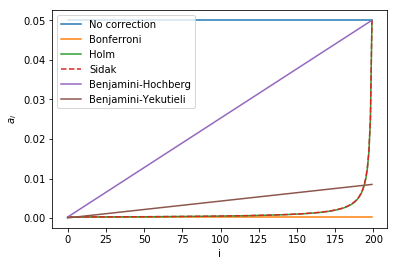

In [7]:
plt.plot([0,m-1], [0.05]*2, label='No correction')
bonferroni = 0.05/m
plt.plot([0,m-1],[bonferroni]*2, label='Bonferroni')

# Holm
holm = 0.05  / np.arange(m, 0, -1)
plt.plot(holm, label='Holm')


#Sidak
sidak = 1 - np.power((1. - 0.05),  1./np.arange(m, 0, -1))
plt.plot(sidak, label='Sidak', ls='--')


# Benjamini-Hochberg
ecdffactor = np.arange(1,m+1)/float(m)
bh = 0.05*ecdffactor
plt.plot(range(m), bh, label='Benjamini-Hochberg' )

#Benjamini-Yekutieli 
cm = np.sum(1./np.arange(1, m+1)) 
ecdffactor = ecdffactor / cm
by = 0.05*ecdffactor
plt.plot(range(m), by, label='Benjamini-Yekutieli ' )


plt.xlabel('i')
plt.ylabel('$a_i$')
plt.legend(loc='best')


Построим графики достигаемых уровней значимостей для разных поправок.

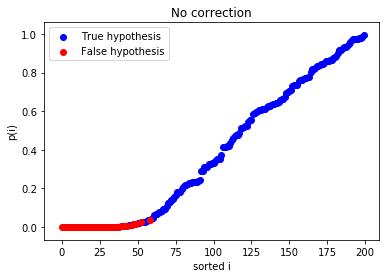

In [8]:
#No corrections
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('No correction')
_=plt.legend(loc='best')

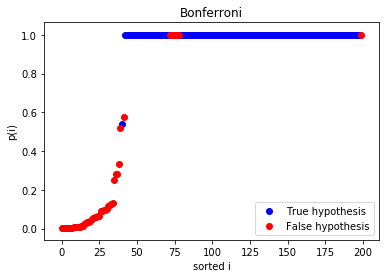

In [9]:
#Bonferroni
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='bonferroni')[1]
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Bonferroni')
_=plt.legend(loc='best')


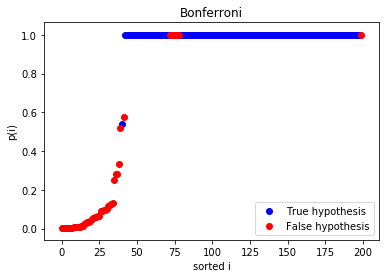

In [15]:
#Bonferroni, без библиотек
p_values = []
for x in X:
     p_values.append(np.min([1, m*st.ttest_1samp(x, 0)[1]]))
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Bonferroni')
_=plt.legend(loc='best')

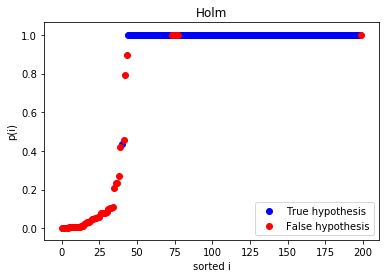

In [11]:
#Holm
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='holm')[1]
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Holm')
_=plt.legend(loc='best')


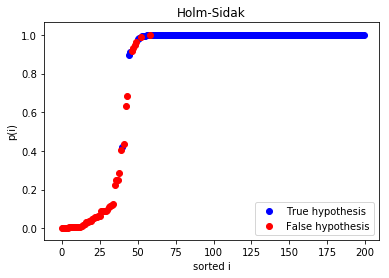

In [12]:
#Holm-Sidak
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='sidak')[1]
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Holm-Sidak')
_=plt.legend(loc='best')


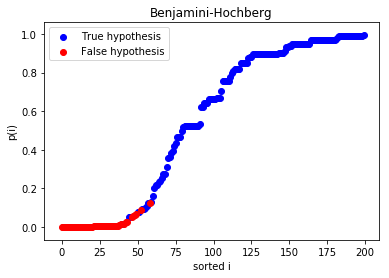

In [23]:
#Benjamini-Hochberg
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='fdr_bh')[1]
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Benjamini-Hochberg')
_=plt.legend(loc='best')


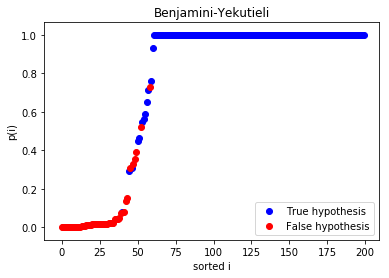

In [24]:
#Benjamini-Yekutieli
p_values = []
for x in X:
     p_values.append(st.ttest_1samp(x, 0)[1])
p_values = multipletests(p_values, method='fdr_by')[1]
argsorted_p = np.argsort(p_values)
false = []
true = []
for i, id in enumerate(argsorted_p):   
    if id>m0:
        false.append((i, p_values[id]))
    else:
        true.append((i, p_values[id]))
plt.scatter(*zip(*true), label='True hypothesis', c='b')
plt.scatter(*zip(*false), label='False hypothesis', c='r')
plt.xlabel('sorted i')
plt.ylabel('p(i)')
plt.title('Benjamini-Yekutieli')
_=plt.legend(loc='best')
